In [ ]:
import pandas as pd
import numpy as np
import string

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 55)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [9]:
import pandas as pd
from datasets import load_dataset

# Завантаження датасету
dataset = load_dataset('mavinsao/reddit-mental-illness-82')
df_tr = dataset['train'].to_pandas()
df_val = dataset['validation'].to_pandas()
df_ts = dataset['test'].to_pandas()
df = pd.concat([df_tr, df_val, df_ts], axis=0, ignore_index=True)

# Перетворення тексту на нижній регістр
df['text'] = df['text'].str.lower()

# Фільтрація рядків за наявністю ключових слів
keywords = [
    "think i have", "i think i have", "i think it might be", "i think i could have",
    "might have", "i might have", "might be", "feel like i have", "i feel like i have",
    "feels like i have", "self-diagnose", "self-diagnosed", "i've self-diagnosed",
    "unsure if i have", "i'm unsure if", "unsure if this is", "wonder if i have",
    "i wonder if i have", "wonder if it's", "symptoms of", "i have symptoms of",
    "experiencing symptoms of", "suspect i have", "i suspect i have", "i suspect it's",
    "probably have", "i probably have", "i think i probably have", "could be", "it could be",
    "seems like i have", "it seems like i have", "it seems like", "not diagnosed but",
    "i am not diagnosed but", "i haven't been diagnosed but"
]

df = df[~df['text'].str.contains('|'.join(keywords), case=False, na=False)]

# Розбиття тексту на заголовок і основний текст
def split_text(row):
    if ':' in row:
        parts = row.split(':', 1)
        return parts[0].strip(), parts[1].strip()
    return None, row.strip()

df[['title', 'main_text']] = df['text'].apply(split_text).apply(pd.Series)

# Перевірка результату
print(df[['title', 'main_text', 'label']])


                                                   title  \
0                              fantasizing about your fp   
1      this is a support subreddit for people with a ...   
2                        scared of my psychotic symptoms   
4      i feel like a sick animal that needs to be put...   
5      is constantly checking ocd subreddits a compul...   
...                                                  ...   
52637  i got diagnosed with pure o, and finding it di...   
52638                 where can i read up on propaganda?   
52639  need help "keeping thoughts straight," or, mai...   
52640  does anyone else feel like none of their exper...   
52641                         wish me luck at work today   

                                               main_text  label  
0      do you do it? what do you fantasize about? : w...      3  
1      it's not for posting how infuriating the uneve...      6  
2      i'm trying to keep reminding myself that what ...      2  
4      i had a 

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
import spacy

# Функція очищення тексту
def clean_text(text):
    text = text.str.lower()
    text = text.str.replace(r'[^\w\s]', '', regex=True)
    text = text.str.replace("\n", '', regex=True)
    text = text.str.replace('\d', '', regex=True)
    text = text.str.replace(r'\[.*?\]', '', regex=True)
    text = text.str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    text = text.str.replace(r'<.*?>+', '', regex=True)
    text = text.str.replace(r'\w*\d\w*', '', regex=True)
    return text

# Функція видалення стоп-слів
# custom_stopwords = {'ocd', 'anxiety', 'adhd', 'ptsd', 'bpd', 'depression', 'bipolar'}
custom_stopwords = {}
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(custom_stopwords)
    text = text.apply(lambda x: " ".join(word for word in str(x).split() if word.lower() not in stop_words))
    return text

# Функція лематизації
nlp = spacy.load('en_core_web_sm')

def lemmatize_sentence(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

# Застосування функцій до обох стовпців (без видалення стоп-слів)
def process_text_columns(df, columns):
    for col in columns:
        # Очищення тексту
        df[col] = clean_text(df[col])
        # Видалення стоп-слів
        # df[col] = remove_stopwords(df[col])
        # Видалення найчастіших слів
        # delete = pd.Series(' '.join(df[col]).split()).value_counts()[-1000:]
        # df[col] = df[col].apply(lambda x: " ".join(word for word in x.split() if word.lower() not in delete))
        #Лематизація
        df[col] = df[col].apply(lemmatize_sentence)
    return df



df = pd.DataFrame(df)
# Застосування функцій до стовпців 'title' і 'main_text'
df = process_text_columns(df, ['title', 'main_text'])
print(df)


                                                    text  label  \
0      fantasizing about your fp: do you do it? what ...      3   
1      this is a support subreddit for people with a ...      6   
2      scared of my psychotic symptoms : i'm trying t...      2   
4      i feel like a sick animal that needs to be put...      4   
5      is constantly checking ocd subreddits a compul...      6   
...                                                  ...    ...   
52637  i got diagnosed with pure o, and finding it di...      6   
52638  where can i read up on propaganda? : i want to...      5   
52639  need help "keeping thoughts straight," or, mai...      0   
52640  does anyone else feel like none of their exper...      1   
52641  wish me luck at work today : oh god my anxiety...      1   

                                                   title  \
0                                fantasize about your fp   
1      this be a support subreddit for people with a ...   
2              

In [11]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


   

# Об'єднання заголовку і основного тексту в один стовпець
df['text'] = df['title'].str.strip(':') + ' ' + df['main_text']
# df['text'] = df['main_text']
# Розподіл на X (тексти) та y (мітки)
X = df['text']
y = df['label']


undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# Застосування undersampling
X_res, y_res = undersampler.fit_resample(X.values.reshape(-1, 1), y)
print("Розподіл класів після балансування:")
print(pd.Series(y_res).value_counts())
balanced_df = pd.DataFrame({
    'text': X_res.flatten(),
    'label': y_res
})

# Розбиття на тренувальний та тестовий набори після балансування
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)
print("\nРозподіл класів у тренувальному наборі:")
print(train_df['label'].value_counts())
print("\nРозподіл класів у тестовому наборі:")
print(test_df['label'].value_counts())


Розподіл класів після балансування:
label
0    4086
1    4086
2    4086
3    4086
4    4086
5    4086
6    4086
7    4086
Name: count, dtype: int64

Розподіл класів у тренувальному наборі:
label
5    3335
0    3296
1    3279
4    3264
6    3264
3    3260
2    3228
7    3224
Name: count, dtype: int64

Розподіл класів у тестовому наборі:
label
7    862
2    858
3    826
6    822
4    822
1    807
0    790
5    751
Name: count, dtype: int64


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

deberta_model_name = 'microsoft/deberta-v3-base'
roberta_model_name = 'roberta-base'

deberta_tokenizer = AutoTokenizer.from_pretrained(deberta_model_name)
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)


def tokenize_data(texts, tokenizer, max_len):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")


max_len = 256
train_texts = train_df['text'].tolist()
test_texts = test_df['text'].tolist()

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])
num_labels = len(label_encoder.classes_)

deberta_train_encodings = tokenize_data(train_texts, deberta_tokenizer, max_len)
deberta_test_encodings = tokenize_data(test_texts, deberta_tokenizer, max_len)

roberta_train_encodings = tokenize_data(train_texts, roberta_tokenizer, max_len)
roberta_test_encodings = tokenize_data(test_texts, roberta_tokenizer, max_len)

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

batch_size = 16

deberta_train_dataset = TextDataset(deberta_train_encodings, y_train)
deberta_test_dataset = TextDataset(deberta_test_encodings, y_test)

roberta_train_dataset = TextDataset(roberta_train_encodings, y_train)
roberta_test_dataset = TextDataset(roberta_test_encodings, y_test)

deberta_train_loader = DataLoader(deberta_train_dataset, batch_size=batch_size, shuffle=True)
deberta_test_loader = DataLoader(deberta_test_dataset, batch_size=batch_size, shuffle=False)

roberta_train_loader = DataLoader(roberta_train_dataset, batch_size=batch_size, shuffle=True)
roberta_test_loader = DataLoader(roberta_test_dataset, batch_size=batch_size, shuffle=False)

# Initialize
deberta_model = AutoModelForSequenceClassification.from_pretrained(deberta_model_name, num_labels=num_labels).to(device)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name, num_labels=num_labels).to(device)

deberta_optimizer = AdamW(deberta_model.parameters(), lr=2e-5)
roberta_optimizer = AdamW(roberta_model.parameters(), lr=2e-5)

epochs = 5

deberta_scheduler = get_linear_schedule_with_warmup(
    deberta_optimizer, num_warmup_steps=0, num_training_steps=len(deberta_train_loader) * epochs)

roberta_scheduler = get_linear_schedule_with_warmup(
    roberta_optimizer, num_warmup_steps=0, num_training_steps=len(roberta_train_loader) * epochs)

# Training
def train_model(model, train_loader, optimizer, scheduler, device, epochs, model_name="Model"):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        for batch in tqdm(train_loader, desc=f"{model_name} - Epoch {epoch+1}/{epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == batch['labels']).sum().item()
            total_predictions += batch['labels'].size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_predictions
        print(f"{model_name} - Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Оцінка моделі окремо
def evaluate_model(model, test_loader, device, label_encoder, model_name="Model"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    print(f"\n{model_name} Evaluation:")
    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(all_labels, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

# Навчання
train_model(deberta_model, deberta_train_loader, deberta_optimizer, deberta_scheduler, device, epochs, model_name="DeBERTa")
train_model(roberta_model, roberta_train_loader, roberta_optimizer, roberta_scheduler, device, epochs, model_name="RoBERTa")

# Оцінка окремо
evaluate_model(deberta_model, deberta_test_loader, device, label_encoder, model_name="DeBERTa")
evaluate_model(roberta_model, roberta_test_loader, device, label_encoder, model_name="RoBERTa")


def evaluate_ensemble(models, test_loaders, device):
    for model in models:
        model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for deberta_batch, roberta_batch in tqdm(zip(*test_loaders), desc="Ensemble Evaluating", total=len(test_loaders[0])):
            deberta_batch = {k: v.to(device) for k, v in deberta_batch.items()}
            roberta_batch = {k: v.to(device) for k, v in roberta_batch.items()}

            deberta_outputs = models[0](**deberta_batch).logits
            roberta_outputs = models[1](**roberta_batch).logits

            # Soft voting
            avg_logits = (deberta_outputs + roberta_outputs) / 2
            preds = torch.argmax(avg_logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(deberta_batch['labels'].cpu().numpy())

    return all_preds, all_labels


y_test_pred, y_test_labels = evaluate_ensemble(
    [deberta_model, roberta_model],
    [deberta_test_loader, roberta_test_loader],
    device
)

print("Ensembled Model Evaluation:")
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test_labels, y_test_pred, target_names=[str(c) for c in label_encoder.classes_]))


Using device: cuda


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
DeBERTa - Epoch 1/5: 100%|██████████| 1635/1635 [24:49<00:00,  1.10it/s]


DeBERTa - Epoch 1/5 - Loss: 0.8954, Accuracy: 0.6967


DeBERTa - Epoch 2/5: 100%|██████████| 1635/1635 [25:00<00:00,  1.09it/s]


DeBERTa - Epoch 2/5 - Loss: 0.5286, Accuracy: 0.8363


DeBERTa - Epoch 3/5: 100%|██████████| 1635/1635 [24:49<00:00,  1.10it/s]


DeBERTa - Epoch 3/5 - Loss: 0.4101, Accuracy: 0.8725


DeBERTa - Epoch 4/5: 100%|██████████| 1635/1635 [25:11<00:00,  1.08it/s]


DeBERTa - Epoch 4/5 - Loss: 0.3116, Accuracy: 0.9054


DeBERTa - Epoch 5/5: 100%|██████████| 1635/1635 [24:49<00:00,  1.10it/s]


DeBERTa - Epoch 5/5 - Loss: 0.2367, Accuracy: 0.9304


RoBERTa - Epoch 1/5: 100%|██████████| 1635/1635 [19:25<00:00,  1.40it/s]


RoBERTa - Epoch 1/5 - Loss: 0.7219, Accuracy: 0.7647


RoBERTa - Epoch 2/5: 100%|██████████| 1635/1635 [19:28<00:00,  1.40it/s]


RoBERTa - Epoch 2/5 - Loss: 0.4681, Accuracy: 0.8503


RoBERTa - Epoch 3/5: 100%|██████████| 1635/1635 [19:15<00:00,  1.42it/s]


RoBERTa - Epoch 3/5 - Loss: 0.3466, Accuracy: 0.8884


RoBERTa - Epoch 4/5: 100%|██████████| 1635/1635 [19:22<00:00,  1.41it/s]


RoBERTa - Epoch 4/5 - Loss: 0.2373, Accuracy: 0.9269


RoBERTa - Epoch 5/5: 100%|██████████| 1635/1635 [19:30<00:00,  1.40it/s]


RoBERTa - Epoch 5/5 - Loss: 0.1665, Accuracy: 0.9515

DeBERTa Evaluation:
Accuracy: 0.8377
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       790
           1       0.75      0.83      0.79       807
           2       0.82      0.77      0.79       858
           3       0.79      0.76      0.77       826
           4       0.72      0.80      0.76       822
           5       0.99      0.98      0.99       751
           6       0.89      0.88      0.89       822
           7       0.87      0.84      0.85       862

    accuracy                           0.84      6538
   macro avg       0.84      0.84      0.84      6538
weighted avg       0.84      0.84      0.84      6538


RoBERTa Evaluation:
Accuracy: 0.8383
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       790
           1       0.77      0.81      0.79       807
           2       0.82      0.76      0.79       858
   

Ensemble Evaluating: 100%|██████████| 409/409 [03:28<00:00,  1.96it/s]

Ensembled Model Evaluation:
Test Accuracy: 0.8507
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       790
           1       0.78      0.84      0.81       807
           2       0.84      0.79      0.81       858
           3       0.81      0.78      0.79       826
           4       0.73      0.80      0.77       822
           5       0.99      0.99      0.99       751
           6       0.91      0.89      0.90       822
           7       0.86      0.86      0.86       862

    accuracy                           0.85      6538
   macro avg       0.85      0.85      0.85      6538
weighted avg       0.85      0.85      0.85      6538



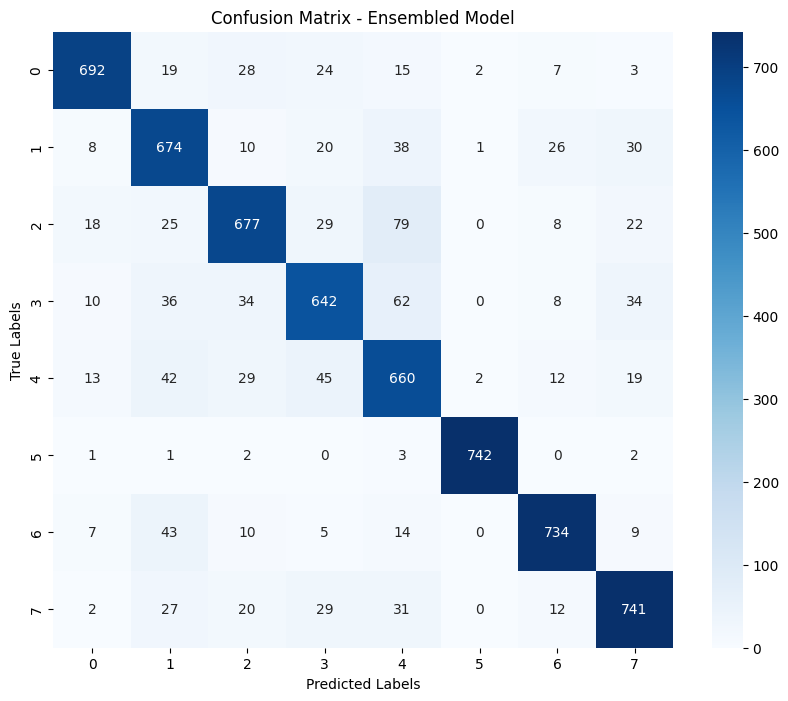

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_labels, y_test_pred)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Ensembled Model')
plt.show()


In [ ]:

deberta_weights_path = '/kaggle/working/deberta_model_weights.pth'
roberta_weights_path = '/kaggle/working/roberta_model_weights.pth'

deberta_fullmodel_path = '/kaggle/working/deberta_full_model.pt'
roberta_fullmodel_path = '/kaggle/working/roberta_full_model.pt'


torch.save(deberta_model.state_dict(), deberta_weights_path)
torch.save(roberta_model.state_dict(), roberta_weights_path)

torch.save(deberta_model, deberta_fullmodel_path)
torch.save(roberta_model, roberta_fullmodel_path)

print(f"DeBERTa weights saved to {deberta_weights_path}")
print(f"RoBERTa weights saved to {roberta_weights_path}")
print(f"DeBERTa full model saved to {deberta_fullmodel_path}")
print(f"RoBERTa full model saved to {roberta_fullmodel_path}")


DeBERTa weights saved to /kaggle/working/deberta_model_weights.pth
RoBERTa weights saved to /kaggle/working/roberta_model_weights.pth
DeBERTa full model saved to /kaggle/working/deberta_full_model.pt
RoBERTa full model saved to /kaggle/working/roberta_full_model.pt


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np
import pandas as pd
import re  # Importing the re module for regular expressions
from nltk.corpus import stopwords
import spacy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

deberta_model = torch.load('/kaggle/working/deberta_full_model.pt', weights_only=False)
roberta_model = torch.load('/kaggle/working/roberta_full_model.pt', weights_only=False)


deberta_model.to(device)
roberta_model.to(device)

deberta_model.eval()
roberta_model.eval()

deberta_tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')
roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')

#  Функція для ансамблевого передбачення 
def ensemble_predict(texts):
    deberta_inputs = deberta_tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
    roberta_inputs = roberta_tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)

    with torch.no_grad():
        deberta_logits = deberta_model(**deberta_inputs).logits
        roberta_logits = roberta_model(**roberta_inputs).logits

        # Soft voting - середнє логітів
        avg_logits = (deberta_logits + roberta_logits) / 2

        preds = torch.argmax(avg_logits, dim=-1)

    predicted_labels = label_encoder.inverse_transform(preds.cpu().numpy())
    return predicted_labels

# Функція очищення тексту
def clean_text(text):
    text = text.lower()  # Перевести текст у нижній регістр
    text = re.sub(r'[^\w\s]', '', text)  # Видалити спеціальні символи
    text = re.sub("\n", '', text)  # Видалити нові рядки
    text = re.sub('\d', '', text)  # Видалити цифри
    text = re.sub(r'\[.*?\]', '', text)  # Видалити текст у квадратних дужках
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Видалити URL
    text = re.sub(r'<.*?>+', '', text)  # Видалити HTML теги
    text = re.sub(r'\w*\d\w*', '', text)  # Видалити слова з цифрами
    return text

# Функція лематизації
nlp = spacy.load('en_core_web_sm')

def lemmatize_sentence(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

def preprocess_texts(texts):
    processed_texts = []
    for text in texts:
        text = clean_text(text)  # Очистити текст
        text = lemmatize_sentence(text)  # Лематизувати текст
        processed_texts.append(text)
    return processed_texts

# Приклад текстів для препроцесингу
texts = [
    "I can't leave the house without checking the door lock at least ten times. If I don't, I feel like something terrible will happen.",
    "My heart races even when I’m just thinking about going to a social event. I keep imagining the worst possible scenarios.",
    "I start a task, then immediately get distracted by something else. I find it almost impossible to stay focused on anything for long.",
    "Loud noises make me jump and flash me back to the accident. I can’t sleep properly and constantly feel on edge.",
    "I constantly feel emotions so intensely that it’s exhausting. One minute I feel like I am loved and valued, and the next I am completely convinced that everyone secretly hates me. Small arguments make me spiral out of control, and I fear abandonment so much that I sometimes push people away first, just to avoid the pain of losing them later.",
    "Every morning I wake up and feel a heavy weight on my chest. Even the simplest tasks like brushing my teeth or answering a message feel overwhelming. It's like there’s no point in anything I do. I isolate myself from friends because I don't want to be a burden, and sometimes I just lie in bed for hours staring at the ceiling, unable to move.",
    " I stay up all night brainstorming business ideas, talking non-stop, jumping from one task to another. I never know how I’ll wake up tomorrow, and that unpredictability scares me the most. I think few persons live in my body",
    "Here's a light-hearted joke for you: Why don't skeletons fight each other? Because they don't have the guts!"
]

# Процесинг текстів
processed_texts = preprocess_texts(texts)

# Далі можна передавати ці оброблені тексти в функцію передбачення ансамблю:
predictions = ensemble_predict(processed_texts)
print(predictions)



[6 1 0 7 3 4 2 5]
